## Modules

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import patches
import seaborn as sns
import os

## Paths

In [2]:
WILDCARDS = ["all", "chromosome", "full", "30"]
project_dir = "/mnt/c/Users/ktmea/Projects/plague-phylogeography-projects/denmark/"
results_dir = project_dir

READS_ORIGIN = WILDCARDS[0]
LOCUS_NAME = WILDCARDS[1]
PRUNE = WILDCARDS[2]
MISSING_DATA = WILDCARDS[3]

CURRENT_YEAR = 2021
BURNIN = 0.1

In [3]:
metadata_path       = project_dir + "metadata/{}/site_metadata.txt".format(READS_ORIGIN)
beast_log_path      = project_dir + "beast/{}/chromosome/full/filter{}/relaxed_clock/dates/run/beast_log.tsv".format(READS_ORIGIN, MISSING_DATA)
out_dir             = project_dir + "beast/{}/chromosome/full/filter{}/relaxed_clock/dates/run/".format(READS_ORIGIN, MISSING_DATA)

## Metadata

In [4]:
site_df = pd.read_csv(metadata_path, sep="\t", encoding="latin-1")
site_df.sort_values(by="date_start", inplace=True)

# Add site numbering
site_dict = {}
site_numbers = []
site_i = 0

for rec in site_df.iterrows():
    site_code = rec[1]["code"]
    if site_code not in site_dict:
        site_i += 1
        number = site_i
        site_dict[site_code] = site_i
    else:
        number = site_dict[site_code] 
    site_numbers.append(number)

site_df["number"] = site_numbers

site_df

,municipality,name,code,date_start,date_end,n,positive,number
1,Ribe,Ribe Lindegården,ASR 13II,900,1000,15,0,1
3,Ribe,Ribe Lindegärden,ASR 2391,900,1000,5,0,2
11,Viborg,Sct. Michael,JAH 1-77,1000,1529,4,0,3
4,Nordby,Nordby,FHM 3970,1050,1250,36,0,4
6,Horsens,Ole Wormsgade,HOM 1649,1100,1500,17,2,5
9,Hågerup,Hågerup,ØHM 1247,1100,1555,7,1,6
10,Refshale,Refshale,Refshale,1100,1350,19,0,7
12,Viborg,The Catholic Church,VSM 09264,1100,1529,6,0,8
13,Viborg,Sct. Mathias,VSM 855F/906F,1100,1529,23,0,9
14,Viborg,Sct. Drotten,VSM 902F,1100,1529,8,0,10


## BEAST Log

In [5]:
log_df = pd.read_csv(beast_log_path, sep="\t", index_col="Sample")

# Discard burnin
burnin_states = round(len(log_df) * BURNIN)
log_df = log_df.iloc[burnin_states:]


danish_samples = {
    "D62" : "G25A",    
    "D71" : "G16", 
    "R36" : "G25B x98",    
    "P387" : "A1480 x1480",
    "P187" : "A146 x3011",    
    "P212" : "G371",
    "D72" : "G207",     
    "D75" : "G861 x1035",         
    "D51" : "Gr GC 15" ,    
    
}
columns = ["height({})".format(sample) for sample in danish_samples]
danish_tip_df = log_df[columns]

# Convert to calendar year
for col in danish_tip_df:
    bp_years = list(danish_tip_df[col])
    calendar_years = [CURRENT_YEAR - year for year in bp_years]
    danish_tip_df[col] = calendar_years

danish_tip_df.columns = list(danish_samples.values())

# Find oldest sample
danish_min_mean = CURRENT_YEAR
danish_max_mean = -CURRENT_YEAR

for column in danish_tip_df:
    mean_date = sum(danish_tip_df[column]) / len(danish_tip_df[column])
    if mean_date < danish_min_mean:
        danish_min_mean = mean_date
    if mean_date > danish_max_mean:
        danish_max_mean = mean_date
        
danish_violin_df = pd.DataFrame({"sample": [], "date": [], })
for column in danish_tip_df.columns:
    dates = list(danish_tip_df[column])
    samples = [column] * len(dates) 
    data_df = pd.DataFrame({"date" : dates, "sample" : samples})
    danish_violin_df = danish_violin_df.append(data_df, ignore_index=True)
    


/home/ktmeaton/miniconda3/envs/plague-phylogeography/lib/python3.7/site-packages/ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


## Intersection

In [6]:
min_date = min(site_df["date_start"])
max_date = max(site_df["date_end"])
interval_date = 10

date_n_dict = {}

for date in range(min_date, max_date + interval_date, interval_date):
    date_n_dict[date] = 0
    
for rec in site_df.iterrows():
    date_start = rec[1]["date_start"]
    date_end = rec[1]["date_end"]
    n = rec[1]["n"]
    
    for date in date_n_dict:

        date_next = date + interval_date
        if date_start >= date and date_start < date_next:
            date_n_dict[date] += n
            
        elif date_start < date and date_end >= date:
            date_n_dict[date] += n

## Plot

/home/ktmeaton/miniconda3/envs/plague-phylogeography/lib/python3.7/site-packages/ipykernel_launcher.py:46: UserWarning: FixedFormatter should only be used together with FixedLocator


/mnt/c/Users/ktmea/Projects/plague-phylogeography-projects/denmark/beast/all/chromosome/full/filter30/relaxed_clock/dates/run/site_timeline


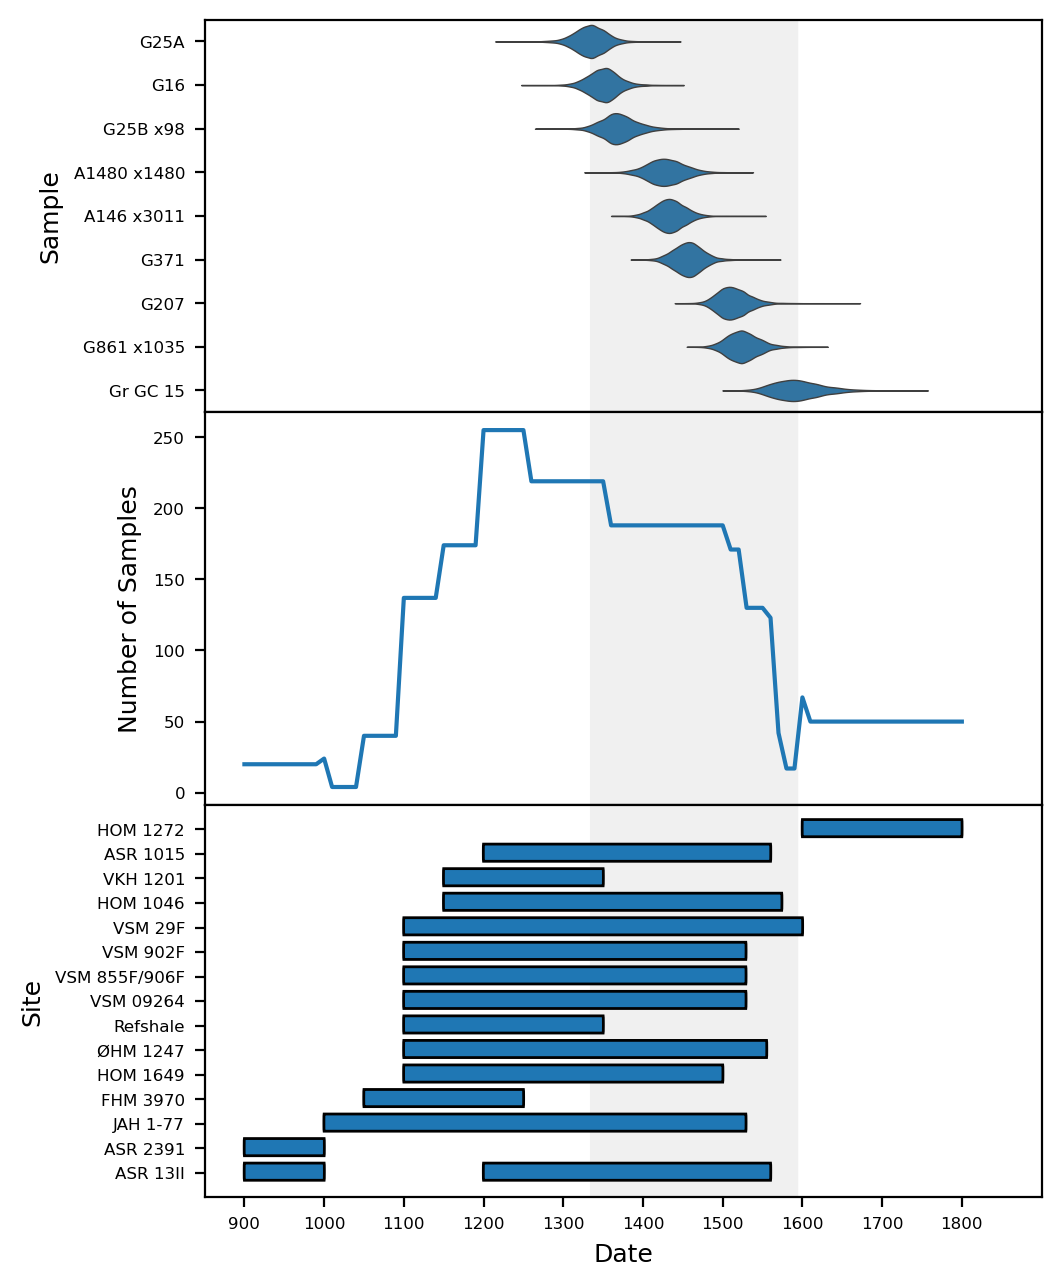

In [7]:
# ---------------------------------------
# PLOT SETUP
TARGET_RES = [1080, 1560]
DPI=200
FIGSIZE=[TARGET_RES[0] / DPI, TARGET_RES[1] / DPI]
FONTSIZE=12

# Setup figure and axis
fig, axes = plt.subplots(3, figsize=FIGSIZE, dpi=DPI, sharex=True)
fig.subplots_adjust(hspace=0)

# ---------------------------------------
# Violin Plots
ax = axes[len(axes) - 3]

# Plot
ax.add_patch(patches.FancyBboxPatch(
    xy     = (danish_min_mean, -1), 
    width  = danish_max_mean - danish_min_mean, 
    height = len(danish_tip_df.columns) + 10,
    boxstyle = "round",
    ec = "none",
    color="#c4c4c4",
    alpha=0.25,
    zorder=0,
))

sns.violinplot(ax=ax, data=danish_violin_df, x="date", y="sample", lw=0.5, color="#1f77b4", inner=None, zorder=2)
ax.set_xlabel("")
ax.set_ylabel("Sample", fontsize=FONTSIZE * 0.75)
ax.set_yticklabels(list(danish_tip_df.columns), fontsize=FONTSIZE / 2)

for collection in ax.collections:
    collection.set_linewidth(0.5)

# ---------------------------------------
# Line graph
ax = axes[len(axes) - 2]
    
ax.set_xlabel("")
ax.set_ylabel("Number of Samples", fontsize=FONTSIZE * 0.75)


# Plot
sns.lineplot(ax=ax, x=list(date_n_dict.keys()), y=list(date_n_dict.values()))
ax.set_yticklabels([round(t) for t in ax.get_yticks()], fontsize=FONTSIZE / 2)
ax.add_patch(patches.FancyBboxPatch(
    xy     = (danish_min_mean, - 10), 
    width  = danish_max_mean - danish_min_mean, 
    height = max(ax.get_yticks()),
    boxstyle = "round",
    ec = "none",
    color="#c4c4c4",
    alpha=0.25,
    zorder=0,
))

# ---------------------------------------
# Rect Graph

ax = axes[len(axes) - 1]


ax.set_xlabel("Date", fontsize=FONTSIZE * 0.75)
ax.set_ylabel("Site", fontsize=FONTSIZE * 0.75)

ax.set_ylim(0,max(site_df["number"]) + 1)
ax.set_xlim(min(site_df["date_start"])-50,max(site_df["date_end"]) + 100)

ax.set_xticks(range(min(site_df["date_start"]),max(site_df["date_end"]) + 100, 100))
ax.set_yticks(range(1, len(site_dict) + 1))

ax.set_xticklabels(ax.get_xticks(), fontsize=FONTSIZE / 2)
ax.set_yticklabels(list(site_dict.keys()), fontsize=FONTSIZE / 2)

# Plot
ax.add_patch(patches.FancyBboxPatch(
    xy     = (danish_min_mean, - 1), 
    width  = danish_max_mean - danish_min_mean, 
    height = len(site_dict) + 10,
    boxstyle = "round",
    ec = "none",
    color="#c4c4c4",
    alpha=0.25,
    zorder=0,
))
for rec in site_df.iterrows():
    date_start = rec[1]["date_start"]
    date_end = rec[1]["date_end"]
    y_coord = rec[1]["number"]
    
    #ax.add_patch(patches.Rectangle((date_start, 0), date_end - date_start, n))
    ax.add_patch(patches.FancyBboxPatch(
        xy     = (date_start, y_coord), 
        width  = date_end - date_start, 
        height = 0.10,
        #height = n,
        boxstyle = "round",
        ec = "black",
        #mutation_aspect=4,
    ))

out_path = os.path.join(out_dir, "site_timeline")
print(out_path)
plt.savefig(out_path + ".png", bbox_inches="tight")
plt.savefig(out_path + ".svg", bbox_inches="tight")